<a href="https://colab.research.google.com/github/PaulSerin/Big-Data-Framework/blob/main/Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercises**

## *Spark environment setup*




In [14]:
import os

os.environ["SPARK_VERSION"] = "spark-3.5.3"
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!echo $SPARK_VERSION-bin-hadoop3.tgz
!rm $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2024-11-26 08:22:45--  http://apache.osuosl.org/spark/spark-3.5.3/sp

In [15]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Big Data Framework/data/"

!rm /content/spark
!ln -s /content/$SPARK_VERSION-bin-hadoop3 /content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin
!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/Big Data Framework/data/


In [16]:
!python -V

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Example: shows the PySpark version
print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.10.12
PySpark version 3.5.3


[2, 3]

In [17]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

In [18]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Exercise 3.1: Word count**

Count the number of words per line in the $DRIVE_DATA/quijote.txt file.

Repeat the exercise but this time counting the number of words in the whole file.

In [19]:
from pyspark.sql import functions as F
# so that we can use the F.split() function.

### Méthode 1 (Dataframe)

In [20]:
from pyspark.sql import functions as F

# Charger le fichier texte dans un DataFrame
file_path = os.environ["DRIVE_DATA"] + "quijote.txt"
df = spark.read.text(file_path).withColumnRenamed("value", "line")

# Étape 2 : Compter les mots par ligne
df_with_word_count = df.withColumn("word_count", F.size(F.split(F.col("line"), " ")))
df_with_word_count.show(10, truncate=False)

# Étape 3 : Compter les mots dans tout le fichier
total_word_count = df_with_word_count.agg(F.sum("word_count").alias("total_word_count"))
total_word_count.show()


+---------------------------------------------------------------------------+----------+
|line                                                                       |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|                                                                           |1         |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|                                                                           |1         |
|                                                                           |1         |
|Title: Don Quijote  

Problem : this method counts 1 word for empty lines.

We will filter thoses empty lines before

In [21]:
df_non_empty = df.filter(F.col("line").isNotNull() & (F.col("line") != ""))
df_with_word_count = df_non_empty.withColumn("word_count", F.size(F.split(F.col("line"), " ")))
df_with_word_count.show(10, truncate=False)

+---------------------------------------------------------------------------+----------+
|line                                                                       |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|Title: Don Quijote                                                         |3         |
|Author: Miguel de Cervantes Saavedra                                       |5         |
|Posting Date: April 27, 2010 [EBook #2000]                                 |7         |
|Release Date: Decemb

### Méthode 2 (RDD)

In [22]:
# Load the text file as an RDD
rdd = sc.textFile(file_path)

# Step 0: Filter out empty lines
# Strip removes leading and trailing whitespaces, and we ensure the line is not empty
rdd_non_empty = rdd.filter(lambda line: line.strip() != "")

# Step 1: Count the number of words per line (excluding empty lines)
# Split each non-empty line into words and count the number of words
word_count_per_line = rdd_non_empty.map(lambda line: len(line.split(" ")))
print("Word count per line (excluding empty lines):")
print(word_count_per_line.take(10))  # Display the first 10 results

# Step 2: Count the total number of words in the file (excluding empty lines)
# Split all non-empty lines into words, flatten the resulting lists, and count the total
total_word_count_rdd = rdd_non_empty.flatMap(lambda line: line.split(" ")).count()
print("Total word count in the file (excluding empty lines):", total_word_count_rdd)


Word count per line (excluding empty lines):
[12, 14, 13, 11, 7, 3, 5, 7, 4, 2]
Total word count in the file (excluding empty lines): 387834


### Méthode 3 (function SQL)

In [23]:
# Create a temporary view
df.createOrReplaceTempView("lines")

# Step 1: Count the number of words per line (excluding empty lines)
# Filter out rows where the line is NULL or empty
word_count_query = """
SELECT line,
       SIZE(SPLIT(line, ' ')) AS word_count
FROM lines
WHERE line IS NOT NULL AND line != ''
"""
df_word_count = spark.sql(word_count_query)
df_word_count.show(10)  # Display the first 10 results

# Step 2: Count the total number of words in the file (excluding empty lines)
# Again, exclude rows where the line is NULL or empty
total_word_count_query = """
SELECT SUM(SIZE(SPLIT(line, ' '))) AS total_word_count
FROM lines
WHERE line IS NOT NULL AND line != ''
"""
df_total_word_count = spark.sql(total_word_count_query)
df_total_word_count.show()  # Display the total word count

+--------------------+----------+
|                line|word_count|
+--------------------+----------+
|The Project Guten...|        12|
|This eBook is for...|        14|
|almost no restric...|        13|
|re-use it under t...|        11|
|with this eBook o...|         7|
|  Title: Don Quijote|         3|
|Author: Miguel de...|         5|
|Posting Date: Apr...|         7|
|Release Date: Dec...|         4|
|   Language: Spanish|         2|
+--------------------+----------+
only showing top 10 rows

+----------------+
|total_word_count|
+----------------+
|          387834|
+----------------+



## **Exercise 4.1: Pi Estimation**

Using the Monte Carlo method, estimate the value of Pi. Use the random() method from the random class.

In [24]:
import random
import numpy as np

### With RDD :

In [25]:
from pyspark.sql import SparkSession

# Step 1: Initialize SparkSession
spark = SparkSession.builder.appName("Pi Estimation").getOrCreate()

# Step 2: Number of points to simulate
NUM_POINTS = 1000000

# Step 3: Create an RDD with NUM_POINTS random samples
rdd = spark.sparkContext.parallelize(range(NUM_POINTS))

# Step 4: Function to determine if a point is inside the unit circle
def is_inside_unit_circle(_):
    x = random.random()
    y = random.random()
    return x**2 + y**2 <= 1

# Step 5: Map points to 1 if inside circle, 0 otherwise
points_inside_circle = rdd.map(is_inside_unit_circle).filter(lambda inside: inside == True).count()

# Step 6: Calculate Pi
pi_estimate = 4 * (points_inside_circle / NUM_POINTS)

# Step 7: Output the result
print(f"Estimated value of Pi using {NUM_POINTS} points: {pi_estimate}")

spark.stop()


Estimated value of Pi using 1000000 points: 3.143184


### With a Dataframe :

In [26]:
from pyspark.sql.functions import rand, pow, col

# Step 0: Initialize SparkSession
spark = SparkSession.builder.appName("Pi Estimation").getOrCreate()

# Step 1: Number of points to simulate
NUM_POINTS = 1000000  # Increase for more accuracy

# Step 2: Create a DataFrame with random x and y points
df_points = (
    spark.range(NUM_POINTS)
    .select(
        rand(seed=0).alias("x"),
        rand(seed=1).alias("y")
    )
)

# Step 3: Add a column to determine if the point is inside the unit circle
df_inside_circle = df_points.withColumn(
    "inside_circle", (pow(col("x"), 2) + pow(col("y"), 2) <= 1).cast("int")
)

# Step 4: Count points inside the circle
points_inside_circle = df_inside_circle.agg({"inside_circle": "sum"}).collect()[0][0]

# Step 5: Calculate Pi
pi_estimate = 4 * (points_inside_circle / NUM_POINTS)

# Step 6: Output the result
print(f"Estimated value of Pi using {NUM_POINTS} points: {pi_estimate}")

spark.stop()


Estimated value of Pi using 1000000 points: 3.137908


## Exercise 4.2: Inspect a log file

Upload the file /var/log/syslog from your computer to this notebook. Then, select only the "bad lines": WARNING and ERROR messages.

In [27]:
from google.colab import files
uploaded = files.upload()

Saving syslog to syslog (1)


In [28]:
!ls

 gdrive   sample_data   spark   spark-3.5.3-bin-hadoop3   syslog  'syslog (1)'


In [29]:
from pyspark.sql import SparkSession

# Step 1: Assuming a SparkSession is already active
# If not, uncomment the line below to initialize it
spark = SparkSession.builder.appName("Inspect Log File").getOrCreate()

# Step 2: Load the syslog file
log_file_path = "/content/syslog"  # Replace with the uploaded file path
rdd = spark.sparkContext.textFile(log_file_path)

# Step 3: Filter lines containing "WARNING" or "ERROR"
bad_lines = rdd.filter(lambda line: "WARNING" in line or "ERROR" in line)

# Step 4: Collect and display the bad lines
bad_lines_collected = bad_lines.collect()
print("Bad lines (WARNING and ERROR messages):")
for line in bad_lines_collected:
    print(line)


Bad lines (WARNING and ERROR messages):
Nov 25 17:22:07 paul-serin ovpn-cytech.students[1358]: WARNING: file '/data/CYTECH-VPN-CLE-PERSONNELLE/client.p12' is group or others accessible
Nov 25 17:22:07 paul-serin ovpn-cytech.students[1358]: WARNING: Your certificate has expired!
Nov 25 17:22:07 paul-serin gnome-session[1456]: gnome-session-binary[1456]: WARNING: Falling back to non-systemd startup procedure due to error: GDBus.Error:org.freedesktop.DBus.Error.Spawn.ChildExited: Process org.freedesktop.systemd1 exited with status 1
Nov 25 17:22:07 paul-serin gnome-session-binary[1456]: WARNING: Falling back to non-systemd startup procedure due to error: GDBus.Error:org.freedesktop.DBus.Error.Spawn.ChildExited: Process org.freedesktop.systemd1 exited with status 1
Nov 25 17:22:15 paul-serin gnome-shell[1481]: JS WARNING: [resource:///org/gnome/shell/ui/layout.js 24]: reference to undefined property "MetaWindowXwayland"
Nov 25 17:22:21 paul-serin gnome-session[2098]: gnome-session-binary[2

Dataframe approach

In [30]:
from pyspark.sql.functions import col, when, lit

# Step 1: Load the syslog file into a DataFrame
df_logs = spark.read.text(log_file_path).withColumnRenamed("value", "line")

# Step 2: Add a column to classify lines as "bad" or "good"
# A "bad" line contains "WARNING" or "ERROR", otherwise it is "good"
df_logs = df_logs.withColumn(
    "is_bad",
    when((col("line").contains("WARNING")) | (col("line").contains("ERROR")), lit(1)).otherwise(lit(0))
)

# Step 3: Count the number of bad and good lines
bad_lines_count = df_logs.filter(col("is_bad") == 1).count()
good_lines_count = df_logs.filter(col("is_bad") == 0).count()

# Step 4: Show results
print(f"Number of bad lines (WARNING or ERROR): {bad_lines_count}")
print(f"Number of good lines: {good_lines_count}")


Number of bad lines (WARNING or ERROR): 37
Number of good lines: 10578


## **Exercise 5.1: Word count**

**Using RDDs**, count the number of lines in the `$DRIVE_DATA/quijote.txt` file. Then, count the number of words in the file. Finally, count the number of *different* words in the file.


In [ ]:
file_path = f"{os.environ['DRIVE_DATA']}quijote.txt"

rdd = spark.sparkContext.textFile(file_path)

rdd = rdd.filter(lambda line: line.strip() != "") # We remove empty lines

num_lines = rdd.count()

num_words = rdd.flatMap(lambda line: line.split(" ")).count()

num_distinct_words = rdd.flatMap(lambda line: line.split(" ")).distinct().count()

print(f"Number of lines: {num_lines}")
print(f"Number of words: {num_words}")
print(f"Number of different words: {num_distinct_words}")


Number of lines: 31931
Number of words: 387834
Number of different words: 40060


## **Exercise 5.2: Count people by age**

Using RDDs, create a barplot showing of number of people (y-axis) per age (x-axis) using the information in the $DRIVE_DATA/people.txt file



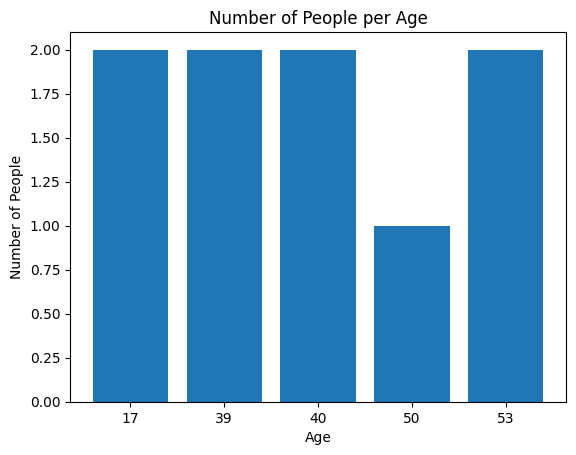

In [ ]:
import matplotlib.pyplot as plt

file_path = f"{os.environ['DRIVE_DATA']}people.txt"

rdd = spark.sparkContext.textFile(file_path)

# Extract age and count occurrences
age_counts = rdd.map(lambda line: line.split("\t")[1])
age_counts = age_counts.map(lambda age: (age, 1)).reduceByKey(lambda x, y: x + y)

# Collect the results
age_counts_data = age_counts.collect()

# Sort for plotting
ages, counts = zip(*sorted(age_counts_data, key=lambda x: int(x[0])))

# Create the bar plot
plt.bar(ages, counts)
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.title("Number of People per Age")
#plt.xticks(rotation=45)
plt.show()


### **Exercise 5.3: Obtain the number of received citations**

Using RDDs, write a PySpark program that obtains, from the cite75_99.txt file, the number of citations received by each patent.


In [31]:
file_path = f"{os.environ['DRIVE_DATA']}cite75_99.txt.tar.bz2"

# Load the file into an RDD
rdd = spark.sparkContext.textFile(file_path)

rdd.take(10)

# Extract cited patents and count citations
citations = rdd.map(lambda line: line.split(",")[1])  # Assuming '->' separates the citing and cited patents
citations_count = citations.map(lambda patent: (patent, 1)).reduceByKey(lambda x, y: x + y)

# Collect and display results
citations_data = citations_count.collect()
print("Number of citations received by each patent:")
for patent, count in sorted(citations_data, key=lambda x: -x[1]):
    print(f"Patent {patent}: {count} citations")


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 8.0 failed 1 times, most recent failure: Lost task 2.0 in stage 8.0 (TID 9) (0a93410557e1 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/content/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/content/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
  File "/content/spark/python/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/content/spark/python/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/content/spark/python/pyspark/rdd.py", line 840, in func
    return f(iterator)
  File "/content/spark/python/pyspark/rdd.py", line 3983, in combineLocally
    merger.mergeValues(iterator)
  File "/content/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 256, in mergeValues
    for k, v in iterator:
  File "/content/spark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-06c2011bb282>", line 9, in <lambda>
IndexError: list index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/content/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/content/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
  File "/content/spark/python/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/content/spark/python/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/content/spark/python/pyspark/rdd.py", line 840, in func
    return f(iterator)
  File "/content/spark/python/pyspark/rdd.py", line 3983, in combineLocally
    merger.mergeValues(iterator)
  File "/content/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 256, in mergeValues
    for k, v in iterator:
  File "/content/spark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-06c2011bb282>", line 9, in <lambda>
IndexError: list index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
